In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Grid environment class

In [2]:
# environment class
class Grid:
    def __init__(self, rows, cols, start):
        self.rows = rows
        self.cols = cols
        self.i = start[0]
        self.j = start[1]
        
    def set(self, rewards, actions):
        self.rewards = rewards
        self.actions = actions
        
    def set_state(self, s):
        self.i = s[0]
        self.j = s[1]
        
    def current_state(self):
        return (self.i, self.j)
    
    def is_terminal(self, s):
        return s not in self.actions
    
    def move(self, action):
        if action in self.actions[(self.i, self.j)]:
            if action == 'U':
                self.i -= 1
            elif action == "D":
                self.i += 1
            elif action == "R":
                self.j += 1
            elif action == "L":
                self.j -= 1
                
        return self.rewards.get((self.i, self.j), 0)
    
    def undo_move(self, action):
        if action == "U":
            self.i += 1
        elif action == "D":
            self.i -= 1
        elif action == "R":
            self.j -= 1
        elif action == "L":
            self.j += 1
        
        assert(self.current_state() in self.all_states())
        
    def game_over(self):
        return (self.i, self.j) not in self.actions
    
    def all_states(self):
        return set(self.actions.keys() | self.rewards.keys())

In [3]:
# grid description
def standard_grid():
    # .  .  .  1
    # .  x  . -1
    # s  .  .  .
    g = Grid(3, 4, (0, 2))
    rewards = {(0, 3): 1, (1, 3): -1}
    actions = {
        (0, 0): ('D', 'R'),
        (0, 1): ('L', 'R'),
        (0, 2): ('L', 'D', 'R'),
        (1, 0): ('D', 'U'),
        (1, 2): ('U', 'D', 'R'),
        (2, 0): ('U', 'R'),
        (2, 1): ('L', 'R'),
        (2, 2): ('L', 'U', 'R'),
        (2, 3): ('L', 'U')
    }
    g.set(rewards, actions)
    
    return g

# a negative grid to limit move times
def negative_grid(step_cost = -0.1):
    g = standard_grid()
    g.rewards.update({
        (0, 0): step_cost,
        (0, 1): step_cost,
        (0, 2): step_cost,
        (1, 0): step_cost,
        (1, 2): step_cost,
        (2, 0): step_cost,
        (2, 1): step_cost,
        (2, 2): step_cost,
        (2, 3): step_cost
    })
    
    return g

In [4]:
# two print functions to display iteration results
def print_value(V, g):
    for i in range(g.rows):
        print('---------------------------')
        for j in range(g.cols):
            v = V.get((i, j), 0)
            if v >= 0:
                print(" %.2f|" % v, end="") # end="" instead of '\n', so the next print wouldn't start a new line
            else:
                print("%.2f|" % v, end="") # '-' takes an extra space
        print("")
        
def print_policy(P, g):
    for i in range(g.rows):
        print('---------------------------')
        for j in range(g.cols):
            p = P.get((i, j), ' ')
            print("  %s  |" % p, end="")
        print("")
    print("")

# Dynamic Programming

If we already know the whole model of Markov decision process (especially the transformation matrix), then we can apply dynamic programming to find the best policy. Dynamic programming typically demands much computation.

## Iteration for policy evaluation

In [13]:
# converge threshold
iteration_thres = 1e-3


def uniform_iteration():
    g = standard_grid()
    states = g.all_states()
    
    V = {}
    for s in states:
        V[s] = 0
    
    gamma = 1.0
    
    while True:
        max_diff = 0
        for s in states:
            old_v = V[s]
            if s in g.actions:
                new_v = 0
                for a in g.actions[s]:
                    g.set_state(s)
                    r = g.move(a)
                    new_v += 1.0/len(g.actions[s]) * (r + gamma * V[g.current_state()])
                V[s] = new_v
                max_diff = max(max_diff, np.abs(V[s] - old_v))
        if max_diff <= iteration_thres:
            break
    
    print("values for uniformly random actions:")
    print_value(V, g)
    print("\n\n")  

In [27]:
def fix_iteration(p):
    g = standard_grid()
    states = g.all_states()
    
    print("policy for fixed policy:")
    print_policy(p, g)
    
    V = {}
    for s in states:
        V[s] = 0
    
    gamma = 0.9
    
    while True:
        max_diff = 0
        for s in states:
            old_v = V[s]
            if s in p:
                g.set_state(s)
                a = p[s]
                r = g.move(a)
                new_v = (r + gamma * V[g.current_state()])
                V[s] = new_v
                max_diff = max(max_diff, np.abs(V[s] - old_v))
        if max_diff <= iteration_thres:
            break
        
    print("values for fixed policy:")
    print_value(V, g)

In [16]:
# uniform iteration
uniform_iteration()

values for uniformly random actions:
---------------------------
-0.03| 0.09| 0.22| 0.00|
---------------------------
-0.16| 0.00|-0.44| 0.00|
---------------------------
-0.29|-0.41|-0.54|-0.77|





In [28]:
# fixed policy iteration
policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U'
}

fix_iteration(policy)

policy for fixed policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |

values for fixed policy:
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00|-1.00| 0.00|
---------------------------
 0.66|-0.81|-0.90|-1.00|


## Policy iteration

In [44]:
# randomly init a policy, then improve it by changing the action and check the value
iteration_thres = 1e-3
gamma = 0.9
all_actions = ['U', 'D', 'L', 'R']

def policy_iteration():
    g = negative_grid()
    
    print('rewards: ')
    print_value(g.rewards, g)
    
    # init policy
    p = {}
    for c in g.actions.keys():
        p[c] = np.random.choice(all_actions)
    print('init policy:')
    print_policy(p, g)
    
        
    # init value
    V = {}
    for s in g.all_states():
        if s in g.actions:
            V[s] = np.random.random()
        else:
            V[s] = 0
    
    states = g.all_states()
    # policy iteration
    while True:
        # policy evaluation
        while True:
            max_diff = 0
            for s in states:
                if s in g.actions:
                    g.set_state(s)
                    old_v = V[s]
                    a = p[s]
                    r = g.move(a)
                    V[s] = (r + gamma * V[g.current_state()])
                    max_diff = max(max_diff, np.abs(V[s] - old_v))
            
            if max_diff <= iteration_thres:
                break
        
        # policy improvement
        is_policy_converge = True
        for s in states:
            if s in g.actions:
                old_a = p[s]
                new_a = None
                best_v = float('-inf')
                for a in all_actions:
                    g.set_state(s)
                    r = g.move(a)
                    new_v = (r + gamma * V[g.current_state()])
                    if new_v > best_v:
                        best_v = new_v
                        new_a = a
                p[s] = new_a
                if new_a != old_a:
                    is_policy_converge = False # only become True when all the s without action change
        
        if is_policy_converge:
            break
        
    print('values:')
    print_value(V, g)
    print('policy:')
    print_policy(p, g)             

In [45]:
policy_iteration()

rewards: 
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
init policy:
---------------------------
  U  |  D  |  U  |     |
---------------------------
  L  |     |  D  |     |
---------------------------
  U  |  U  |  R  |  D  |

values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |



## Value iteration

Policy iteration tries to loop between 'evaluate the value of a policy' and 'improve the policy with the value', while value iteration tries to find a roughly good value, then loop the policy using that value to find an optimal policy. Theoretically, value iteration is more efficient.

In [58]:
iteration_thres = 1e-3
gamma = 0.9
all_actions = ['U', 'D', 'L', 'R']

def value_iteration():
    g = negative_grid()
    
    print('rewards: ')
    print_value(g.rewards, g)
    
    # init policy
    p = {}
    for c in g.actions.keys():
        p[c] = np.random.choice(all_actions)
    print('init policy:')
    print_policy(p, g)
    
        
    # init value
    V = {}
    for s in g.all_states():
        if s in g.actions:
            V[s] = np.random.random()
        else:
            V[s] = 0
    
    states = g.all_states()
    # find V
    while True:
        max_diff = 0
        for s in states:
            old_v = V[s]
            if s in g.actions:
                best_v = float('-inf')
                for a in all_actions:
                    g.set_state(s)
                    r = g.move(a)
                    new_v = (r + gamma * V[g.current_state()])
                    best_v = max(best_v, new_v)
                V[s] = best_v
                max_diff = max(max_diff, np.abs(V[s] - old_v))
        if max_diff <= iteration_thres:
            break
    
    # value iteration
    for s in g.actions:
        best_v = float('-inf')
        best_a = None
        for a in all_actions:
            g.set_state(s)
            r = g.move(a)
            new_v = (r + gamma * V[g.current_state()])
            if new_v > best_v:
                best_v = new_v
                best_a = a
        p[s] = best_a
            
    print('values:')
    print_value(V, g)
    print('policy:')
    print_policy(p, g)             

In [59]:
value_iteration()

rewards: 
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
init policy:
---------------------------
  L  |  U  |  D  |     |
---------------------------
  D  |     |  D  |     |
---------------------------
  D  |  R  |  U  |  L  |

values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |



# Monte Carlo

If we don't know the transformation matrix of the MDP, we can only let the agent try all those actions and calculate the value from its experience.

## Monte Carlo method with Exploring Starts

Exploring starts method works for those situations that one game can have couple of starting points. Each state-action pair has a non-zero probability to be selected as starting point, then we can greedily choose the best action to improve our policy.

In [19]:
gamma = 0.9
all_actions = ('U', 'D', 'L', 'R')

def play_game_es(g, p):
    # randomly pick one state
    starting_state_idx = np.random.choice(len(list(g.actions.keys())))
    g.set_state(list(g.actions.keys())[starting_state_idx])
    
    # randomly pick one action
    s = g.current_state()
    a = np.random.choice(all_actions)
    
    # episode, notice the states_actions_rewards stores (s(t), a(t), r(t-1)), r comes from the previous s and a
    states_actions_rewards = [(s, a, 0)]
    seen_states = set()
    seen_states.add(s)
    num_steps = 0
    
    while True:
        r = g.move(a)
        s = g.current_state()
        num_steps += 1
        
        if s in seen_states:
            reward = -10./num_steps
            states_actions_rewards.append((s, None, reward))
            break
        elif g.game_over():
            states_actions_rewards.append((s, None, r))
            break
        else:
            a = p[s]
            states_actions_rewards.append((s, a, r))
        seen_states.add(s)
    
    # calculate returns by reversing the states_actions_rewards
    G = 0
    states_actions_returns = []
    first = True
    
    for s, a, r in reversed(states_actions_rewards):
        if first:
            # we don't want to put the end state as it doesn't have any move
            first = False
        else:
            states_actions_returns.append((s, a, G))
        G = r + gamma * G
    states_actions_returns.reverse()
    
    return states_actions_returns

In [20]:
# util function to return the max value from a dictionary
def max_dict(d):
    max_key = None
    max_v = float('-inf')
    for k, v in d.items():
        if v > max_v:
            max_key = k
            max_v = v
    return max_key, max_v

In [23]:
# Monte Carlo policy optimization with exploring starts
def MC_es():
    g = negative_grid(step_cost=-0.9)
    
    # init policy
    p = {}
    for s in g.actions:
        p[s] = np.random.choice(all_actions)
    
    # init Q(s, a)
    Q = {}
    returns = {}
    states = g.all_states()
    for s in states:
        if s in g.actions:
            Q[s] = {}
            for a in all_actions:
                Q[s][a] = 0
                returns[(s, a)] = []
        else:
            pass
    
    # for printing
    deltas = []
    for t in range(2000):
        if t % 100 == 0:
            print(t)
        
        # episode manipulation
        max_diff = 0
        states_actions_returns = play_game_es(g, p)
        seen_state_action = set()
        for s, a, G in states_actions_returns:
            sa = (s, a)
            if sa not in seen_state_action:
                old_v = Q[s][a]
                returns[sa].append(G)
                Q[s][a] = np.mean(returns[sa])
                max_diff = max(max_diff, np.abs(Q[s][a] - old_v))
                seen_state_action.add(sa)
        deltas.append(max_diff)
        
        # policy improve
        for s in p.keys():
            p[s] = max_dict(Q[s])[0]
        
    plt.plot(deltas)
    plt.show()
    
    print("final policy:")
    print_policy(p, g)
    
    V = {}
    for s, Qs in Q.items():
        V[s] = max_dict(Q[s])[1]
    
    print("final values:")
    print_value(V, g)          

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


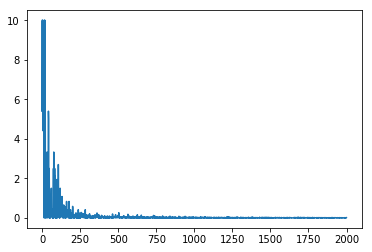

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  R  |  R  |  U  |  U  |

final values:
---------------------------
-1.98|-1.08| 1.00| 0.00|
---------------------------
-3.11| 0.00|-0.77| 0.00|
---------------------------
-3.19|-2.66|-1.89|-1.00|


In [24]:
MC_es()